In [2]:
import os
import sys
from torch.utils.data import Dataset

from PIL import Image

# a class specialized for Tiny-ImageNet that can read it correctly
class TinyImageNet(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.Train = train
        self.root_dir = root
        self.transform = transform
        self.train_dir = os.path.join(self.root_dir, "train")
        self.val_dir = os.path.join(self.root_dir, "val")

        if (self.Train):
            self._create_class_idx_dict_train()
        else:
            self._create_class_idx_dict_val()

        self._make_dataset(self.Train)

        words_file = os.path.join(self.root_dir, "words.txt")
        wnids_file = os.path.join(self.root_dir, "wnids.txt")

        self.set_nids = set()

        with open(wnids_file, 'r') as fo:
            data = fo.readlines()
            for entry in data:
                self.set_nids.add(entry.strip("\n"))

        self.class_to_label = {}
        with open(words_file, 'r') as fo:
            data = fo.readlines()
            for entry in data:
                words = entry.split("\t")
                if words[0] in self.set_nids:
                    self.class_to_label[words[0]] = (words[1].strip("\n").split(","))[0]

    def _create_class_idx_dict_train(self):
        if sys.version_info >= (3, 5):
            classes = [d.name for d in os.scandir(self.train_dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(self.train_dir) if os.path.isdir(os.path.join(train_dir, d))]
        classes = sorted(classes)
        num_images = 0
        for root, dirs, files in os.walk(self.train_dir):
            for f in files:
                if f.endswith(".JPEG"):
                    num_images = num_images + 1

        self.len_dataset = num_images;

        self.tgt_idx_to_class = {i: classes[i] for i in range(len(classes))}
        self.class_to_tgt_idx = {classes[i]: i for i in range(len(classes))}

    def _create_class_idx_dict_val(self):
        val_image_dir = os.path.join(self.val_dir, "images")
        if sys.version_info >= (3, 5):
            images = [d.name for d in os.scandir(val_image_dir) if d.is_file()]
        else:
            images = [d for d in os.listdir(val_image_dir) if os.path.isfile(os.path.join(train_dir, d))]
        val_annotations_file = os.path.join(self.val_dir, "val_annotations.txt")
        self.val_img_to_class = {}
        set_of_classes = set()
        with open(val_annotations_file, 'r') as fo:
            entry = fo.readlines()
            for data in entry:
                words = data.split("\t")
                self.val_img_to_class[words[0]] = words[1]
                set_of_classes.add(words[1])

        self.len_dataset = len(list(self.val_img_to_class.keys()))
        classes = sorted(list(set_of_classes))
        # self.idx_to_class = {i:self.val_img_to_class[images[i]] for i in range(len(images))}
        self.class_to_tgt_idx = {classes[i]: i for i in range(len(classes))}
        self.tgt_idx_to_class = {i: classes[i] for i in range(len(classes))}

    def _make_dataset(self, Train=True):
        self.images = []
        if Train:
            img_root_dir = self.train_dir
            list_of_dirs = [target for target in self.class_to_tgt_idx.keys()]
        else:
            img_root_dir = self.val_dir
            list_of_dirs = ["images"]

        for tgt in list_of_dirs:
            dirs = os.path.join(img_root_dir, tgt)
            if not os.path.isdir(dirs):
                continue

            for root, _, files in sorted(os.walk(dirs)):
                for fname in sorted(files):
                    if (fname.endswith(".JPEG")):
                        path = os.path.join(root, fname)
                        if Train:
                            item = (path, self.class_to_tgt_idx[tgt])
                        else:
                            item = (path, self.class_to_tgt_idx[self.val_img_to_class[fname]])
                        self.images.append(item)

    def return_label(self, idx):
        return [self.class_to_label[self.tgt_idx_to_class[i.item()]] for i in idx]

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, idx):
        img_path, tgt = self.images[idx]
        with open(img_path, 'rb') as f:
            sample = Image.open(img_path)
            sample = sample.convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)

        return sample, tgt

In [3]:
import torch
import torchvision.transforms as transforms

path = '/Users/royalty/Desktop/Python_ML/Python-DL/second_assignment/tiny-imagenet-200'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        
transform_train = transforms.Compose([
            transforms.RandomCrop(64, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.5),transforms.ToTensor(),
            normalize,
        ])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            normalize,
            ])
        
train_dataset = TinyImageNet(path, transform=transform_train, train=True)
val_dataset = TinyImageNet(path, transform=transform_test, train=False)

In [6]:
train_dataset.class_to_label == val_dataset.class_to_label

True

In [15]:
import torchvision.models as models
import torch.backends.cudnn as cudnn

# import the pth data, which was trained on 4 GPUs. make it run on CPU
device = torch.device("cpu")
save_path = "./model_5.pth"

net = models.resnet18(pretrained = False, num_classes = 200)

cudnn.benchmark = True

# load the model trained on 4 GPUs
net.load_state_dict({k.replace('module.',''):v for k,v in torch.load(save_path, map_location = device).items()})

# test the model with validation set
correct = 0
total = 0
with torch.no_grad():
    for data in val_dataset:
        images, labels = data
        outputs = net(images.unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += (predicted == labels).sum().item()
        
correct/total

0.0082

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11110 torch.Size([3, 64, 64]) 22 ['albatross'] ['albatross']


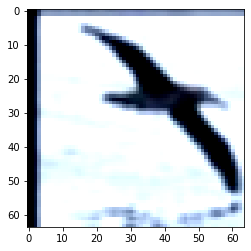

Predicted:  [ ' b u c k e t ' ]


In [16]:
# test the model with the first 4 images in the training set
for i in range(11110, 11111):
    sample = train_dataset[i]
    print(i, sample[0].size(), sample[1],train_dataset.return_label(torch.tensor([sample[1]])),val_dataset.return_label(torch.tensor([sample[1]])))
    # show images
    imshow(sample[0])
    # predict the label
    outputs = net(sample[0].unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted: ', ' '.join('%5s' % train_dataset.return_label(predicted)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


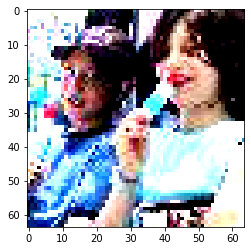

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['ice lolly'] 
val idation set label: ['ice lolly']
Predicted:  [ ' b u c k e t ' ]


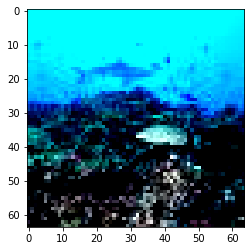

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['coral reef'] 
val idation set label: ['coral reef']
Predicted:  [ ' p l u n g e r ' ]


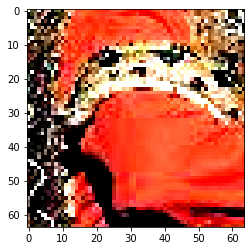

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['boa constrictor'] 
val idation set label: ['boa constrictor']
Predicted:  [ ' b u c k e t ' ]


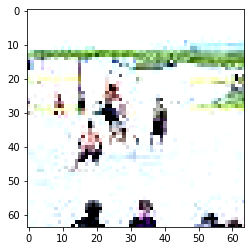

train set label:  ['volleyball'] 
val idation set label: ['volleyball']
Predicted:  [ ' c a n n o n ' ]


In [39]:
# test the model with the first 4 images in the validation set
for i in range(120, 124):
    sample = val_dataset[i]
    # show images
    imshow(sample[0])
    # predict the label
    outputs = net(sample[0].unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    print("train set label: ",train_dataset.return_label(torch.tensor([sample[1]])),"\nval idation set label:",val_dataset.return_label(torch.tensor([sample[1]])))
    print('Predicted: ', ' '.join('%5s' % train_dataset.return_label(predicted)))

In [40]:
# import the pth data, which was trained on 4 GPUs. make it run on CPU
device = torch.device("cpu")
save_path = "./model_10.pth"

net_10_epoch = models.resnet18(pretrained = False, num_classes = 200)

cudnn.benchmark = True

# load the model trained on 4 GPUs
net_10_epoch.load_state_dict({k.replace('module.',''):v for k,v in torch.load(save_path, map_location = device).items()})

# import the pth data, which was trained on 4 GPUs. make it run on CPU
device = torch.device("cpu")
save_path = "./model_50.pth"

net_50_epoch = models.resnet18(pretrained = False, num_classes = 200)

cudnn.benchmark = True

# load the model trained on 4 GPUs
net_50_epoch.load_state_dict({k.replace('module.',''):v for k,v in torch.load(save_path, map_location = device).items()})

/Users/royalty/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/royalty/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


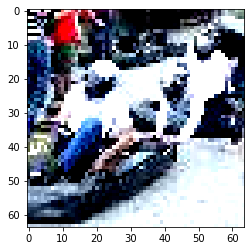

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['go-kart'] 
val idation set label: ['go-kart']
Predicted_10:  [ ' b u c k e t ' ]
Predicted_50:  [ ' c h a i n ' ]




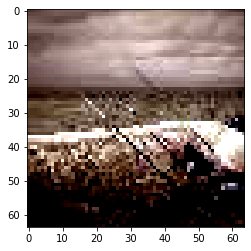

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['reel'] 
val idation set label: ['reel']
Predicted_10:  [ ' f o u n t a i n ' ]
Predicted_50:  [ ' r e e l ' ]




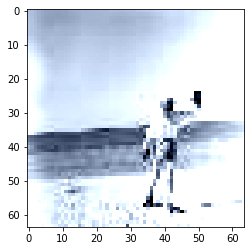

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['swimming trunks'] 
val idation set label: ['swimming trunks']
Predicted_10:  [ ' u m b r e l l a ' ]
Predicted_50:  [ ' b u c k e t ' ]




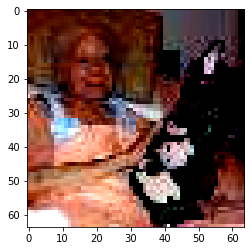

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['Christmas stocking'] 
val idation set label: ['Christmas stocking']
Predicted_10:  [ ' p o p   b o t t l e ' ]
Predicted_50:  [ ' t e a p o t ' ]




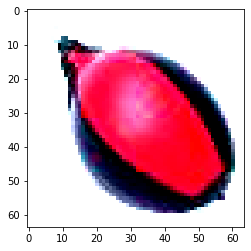

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['punching bag'] 
val idation set label: ['punching bag']
Predicted_10:  [ ' u m b r e l l a ' ]
Predicted_50:  [ ' b r o o m ' ]




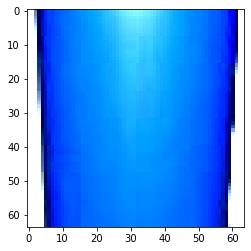

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['barrel'] 
val idation set label: ['barrel']
Predicted_10:  [ ' s o m b r e r o ' ]
Predicted_50:  [ ' a p r o n ' ]




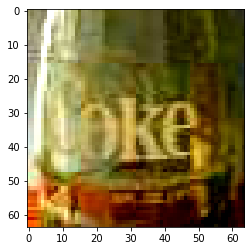

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['pop bottle'] 
val idation set label: ['pop bottle']
Predicted_10:  [ ' w o o d e n   s p o o n ' ]
Predicted_50:  [ ' a b a c u s ' ]




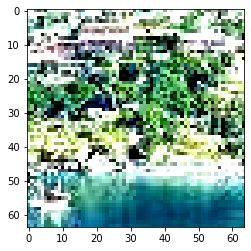

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['seashore'] 
val idation set label: ['seashore']
Predicted_10:  [ ' u m b r e l l a ' ]
Predicted_50:  [ ' b i n o c u l a r s ' ]




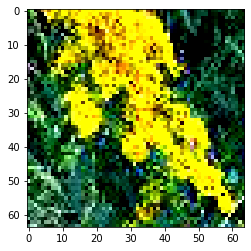

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['bee'] 
val idation set label: ['bee']
Predicted_10:  [ ' b a n n i s t e r ' ]
Predicted_50:  [ ' t e d d y ' ]




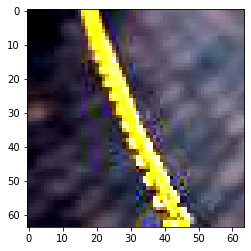

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['chain'] 
val idation set label: ['chain']
Predicted_10:  [ ' r e e l ' ]
Predicted_50:  [ ' b u c k e t ' ]




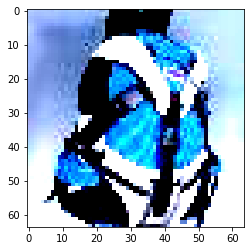

train set label:  ['backpack'] 
val idation set label: ['backpack']
Predicted_10:  [ ' b u c k e t ' ]
Predicted_50:  [ ' b u c k e t ' ]




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


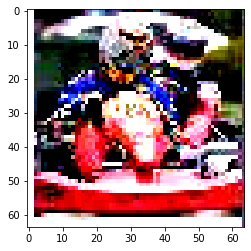

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['go-kart'] 
val idation set label: ['go-kart']
Predicted_10:  [ ' s t a n d a r d   p o o d l e ' ]
Predicted_50:  [ ' p l u n g e r ' ]




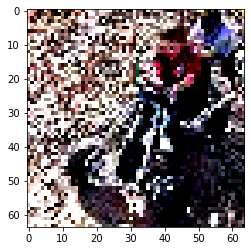

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['go-kart'] 
val idation set label: ['go-kart']
Predicted_10:  [ ' u m b r e l l a ' ]
Predicted_50:  [ ' d r u m s t i c k ' ]




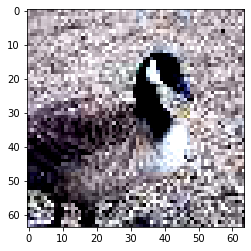

train set label:  ['goose'] 
val idation set label: ['goose']
Predicted_10:  [ ' u m b r e l l a ' ]
Predicted_50:  [ ' i c e   l o l l y ' ]




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


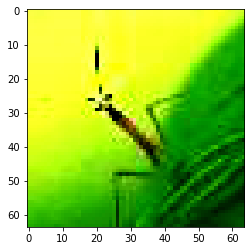

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train set label:  ['mantis'] 
val idation set label: ['mantis']
Predicted_10:  [ ' u m b r e l l a ' ]
Predicted_50:  [ ' b i r d h o u s e ' ]




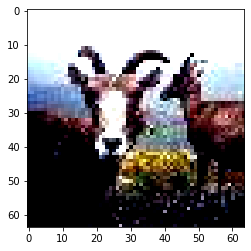

train set label:  ['bighorn'] 
val idation set label: ['bighorn']
Predicted_10:  [ ' b a r r e l ' ]
Predicted_50:  [ ' b i r d h o u s e ' ]




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


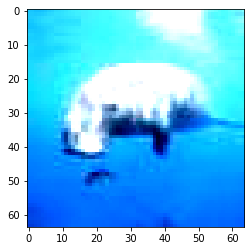

train set label:  ['dugong'] 
val idation set label: ['dugong']
Predicted_10:  [ ' u m b r e l l a ' ]
Predicted_50:  [ ' s p a c e   h e a t e r ' ]




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


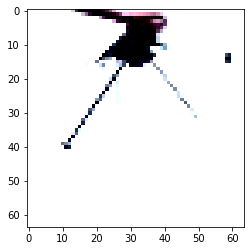

train set label:  ['turnstile'] 
val idation set label: ['turnstile']
Predicted_10:  [ ' u m b r e l l a ' ]
Predicted_50:  [ ' b u c k e t ' ]




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


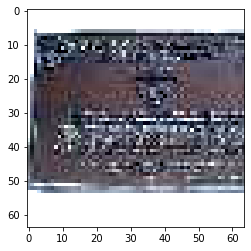

train set label:  ['brass'] 
val idation set label: ['brass']
Predicted_10:  [ ' s p i n y   l o b s t e r ' ]
Predicted_50:  [ ' t a b b y ' ]




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


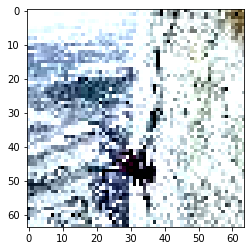

train set label:  ['cliff'] 
val idation set label: ['cliff']
Predicted_10:  [ ' r e e l ' ]
Predicted_50:  [ ' p o p   b o t t l e ' ]




In [41]:
# find 10 images predicted differently by the model trained on 10 epochs and the model trained on 50 epochs

for i in range(20):
    sample = val_dataset[i]
    # show images
    imshow(sample[0])
    # predict the label
    outputs_10 = net_10_epoch(sample[0].unsqueeze(0))
    _, predicted_10 = torch.max(outputs_10.data, 1)
    outputs_50 = net_50_epoch(sample[0].unsqueeze(0))
    _, predicted_50 = torch.max(outputs_50.data, 1)
    print("train set label: ",train_dataset.return_label(torch.tensor([sample[1]])),"\nval idation set label:",val_dataset.return_label(torch.tensor([sample[1]])))
    print('Predicted_10: ', ' '.join('%5s' % train_dataset.return_label(predicted_10)))
    print('Predicted_50: ', ' '.join('%5s' % train_dataset.return_label(predicted_50)))
    print("\n")

In [43]:
train_dataset.class_to_label

{'n01443537': 'goldfish',
 'n01629819': 'European fire salamander',
 'n01641577': 'bullfrog',
 'n01644900': 'tailed frog',
 'n01698640': 'American alligator',
 'n01742172': 'boa constrictor',
 'n01768244': 'trilobite',
 'n01770393': 'scorpion',
 'n01774384': 'black widow',
 'n01774750': 'tarantula',
 'n01784675': 'centipede',
 'n01855672': 'goose',
 'n01882714': 'koala',
 'n01910747': 'jellyfish',
 'n01917289': 'brain coral',
 'n01944390': 'snail',
 'n01945685': 'slug',
 'n01950731': 'sea slug',
 'n01983481': 'American lobster',
 'n01984695': 'spiny lobster',
 'n02002724': 'black stork',
 'n02056570': 'king penguin',
 'n02058221': 'albatross',
 'n02074367': 'dugong',
 'n02085620': 'Chihuahua',
 'n02094433': 'Yorkshire terrier',
 'n02099601': 'golden retriever',
 'n02099712': 'Labrador retriever',
 'n02106662': 'German shepherd',
 'n02113799': 'standard poodle',
 'n02123045': 'tabby',
 'n02123394': 'Persian cat',
 'n02124075': 'Egyptian cat',
 'n02125311': 'cougar',
 'n02129165': 'lion'

In [44]:
train_dataset.class_to_label == val_dataset.class_to_label


True